In [2]:
%matplotlib inline
%matplotlib nbagg

from typing import *
from IPython.display import Image, display, clear_output

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"
print(f">> Using device: {device}")

>> Using device: cuda:0


# 1. Introduction

##  1.1) Load data

Load the EEG data using our dataloader. The python scipt for generating dataset can be found in the Code folder, as well as a dataloader function building on work done by David Enslev s123997. The batch_loader is a function for class made for loading our dataset.

In [3]:
from Code.Dataloader import batch_loader
Data_train_path=r"C:\Users\Andre\Desktop\Deeplearning local\DeepLearning-VAE\Data\Fourier_0_overlab_train"
Data_validation_path=r"C:\Users\Andre\Desktop\Deeplearning local\DeepLearning-VAE\Data\Fourier_0_overlab_validation"

train_set=batch_loader(Data_train_path,device)
train_set.pre_load()

validation_set=batch_loader(Data_validation_path,device)
validation_set.pre_load()



## 1.2) Plot randomly chosen samples on a grid

In [14]:
X,Y,meta=validation_set.load_random(1)

[{'File index': 21, 'window index': 768}]


<IPython.core.display.Javascript object>


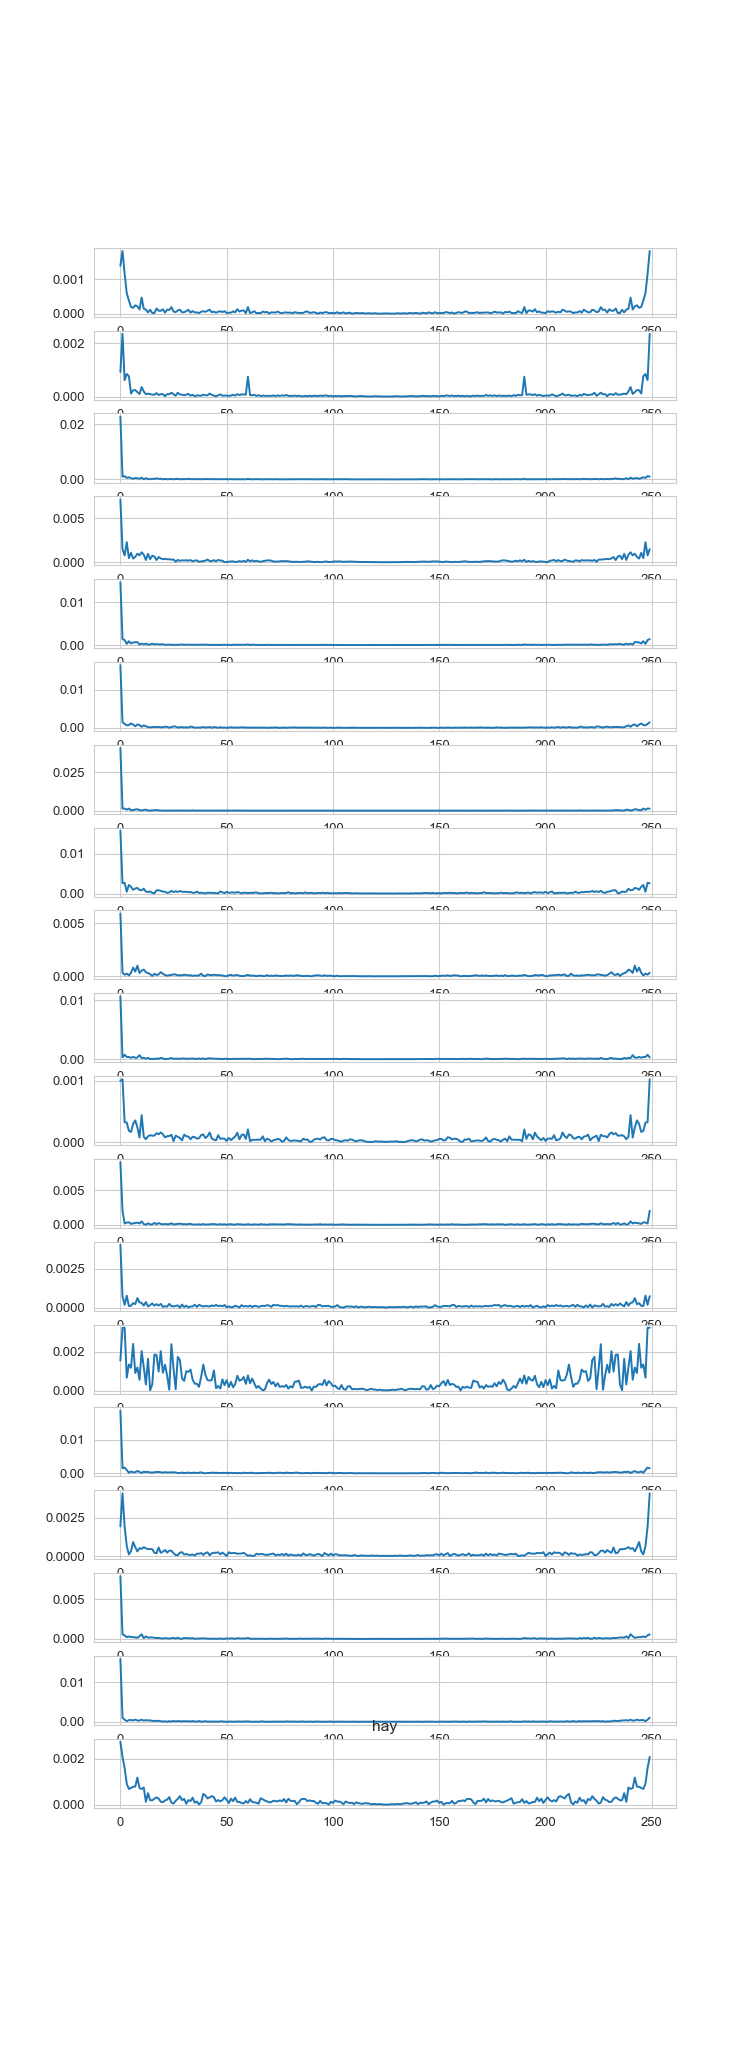

In [17]:
from Code.plots import plot_samples
print(meta)
plot_samples(X.cpu(),"")


# 2. VAE Implementation

We made a pipeline for training VAR models, that can be found in the code as Experiment_setup.py 
Our VAE implementation can be seen in VAE.py

In [4]:
from Code.Experiment_setup import VEA_experiment
from Code.VAE import VariationalAutoencoder, VariationalInference

In [5]:
#Difine some paths for saving the results
save_path=r"Dense3/"
Experiment_name=r"test"

## 2.1 Setting up the model

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
#Difine hyper paremeters
batch_size=32
n_batches=10  #How many batches for each epochs
latent_features=2 #Number of dimensions on latent layer

VAE_EX=VEA_experiment(Data_loader_train=train_set,Data_loader_validation=validation_set,batch_size=batch_size,
                  n_batches=n_batches,latent_features=latent_features)
#VAE_EX.make_logfile(save_path+Experiment_name+"_log.txt","Test")

In [103]:
from torch import nn
encoder = nn.Sequential(
    nn.Linear(in_features=4750, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256,out_features=128),
    nn.ReLU(),
    # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
    nn.Linear(in_features=128, out_features=2 * latent_features)  # <- note the 2*latent_features
)

decoder = nn.Sequential(
    nn.Linear(in_features=latent_features, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=4750*2)
)


#Replace the encoder and decoder
VAE_EX.swap_nn(encoder,decoder,flaten=True)

VariationalAutoencoder(
  (vi): VariationalInference()
  (encoder): Sequential(
    (0): Linear(in_features=4750, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=9500, bias=True)
  )
)


### (Report)Generate 64 samples from theuntrained modeland plot them on a 8×8 grid

In [94]:
untrained_samples = VAE_EX.VAE.sample(X)

<IPython.core.display.Javascript object>


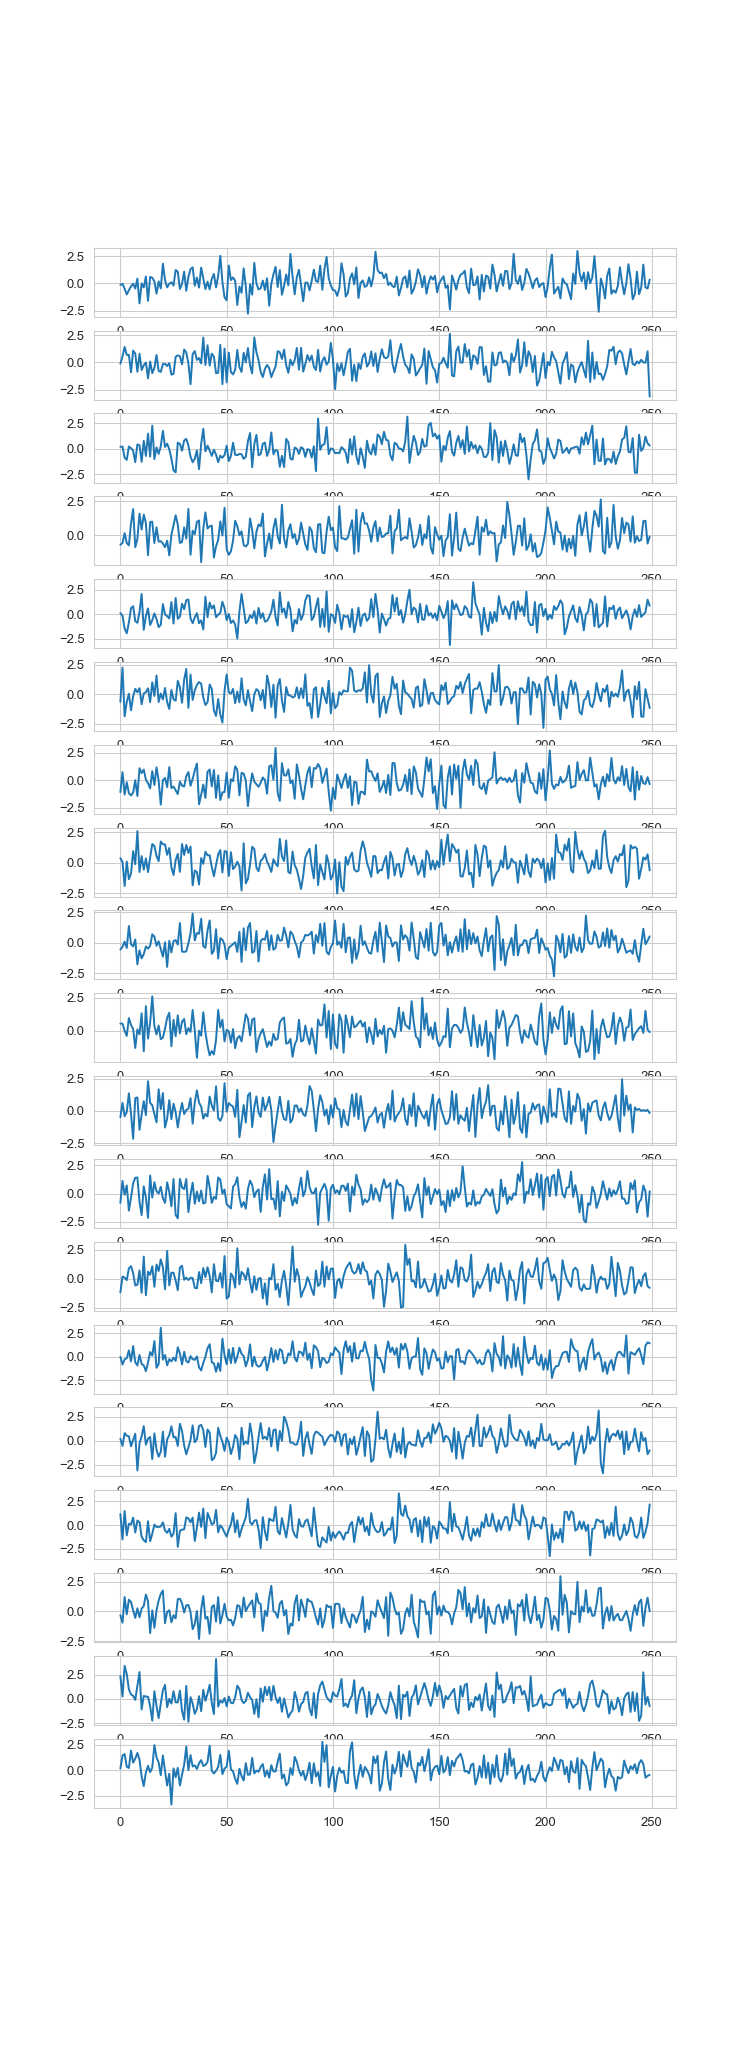

In [95]:

plot_samples(untrained_samples.cpu(),"")

## 2.2 training the model

Epoch 0/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100


<IPython.core.display.Javascript object>


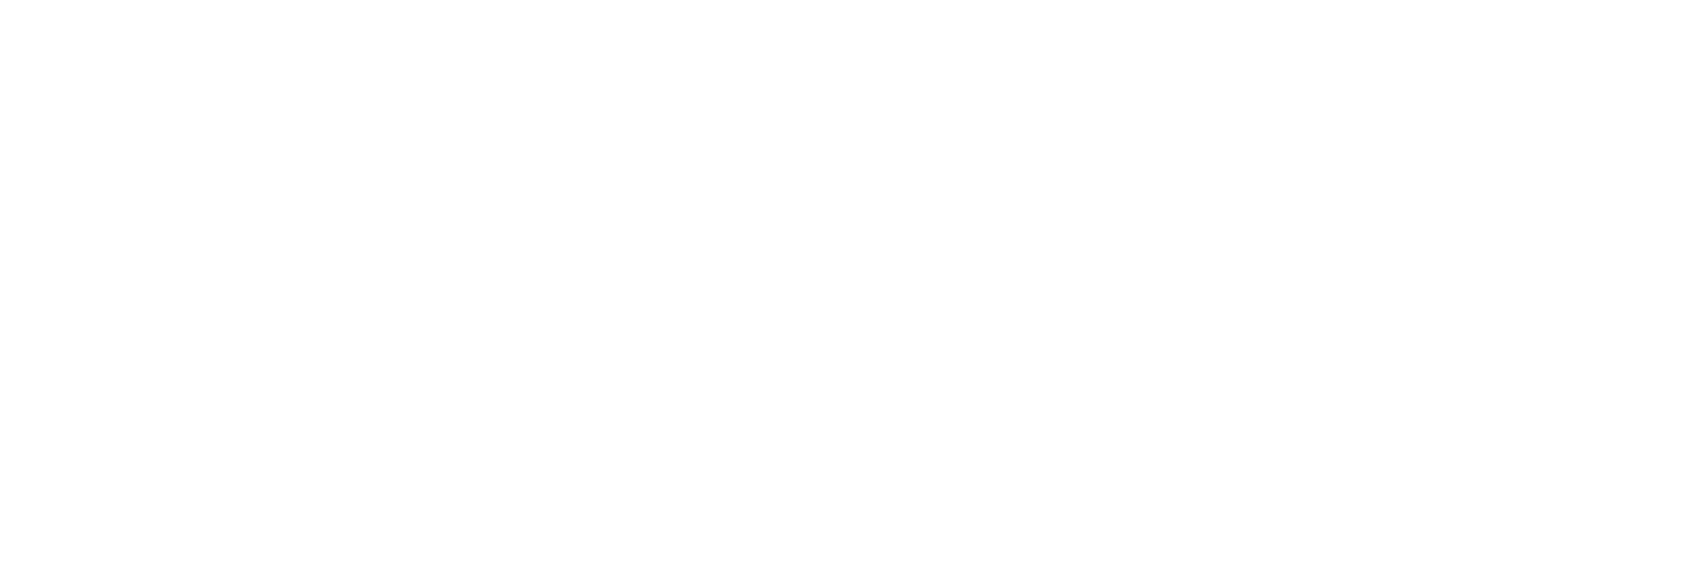

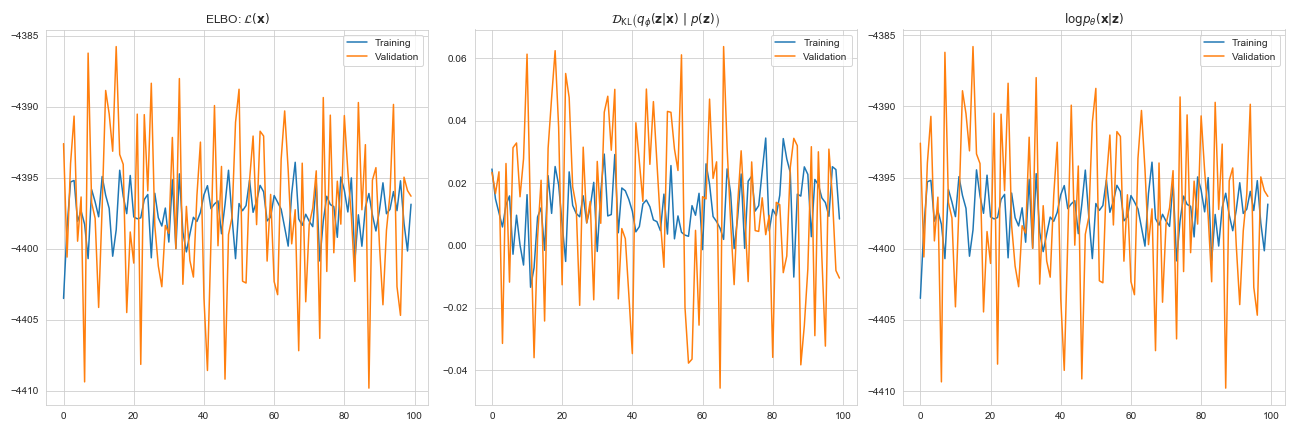

In [104]:
n_epoke=100
VAE_EX.run(num_epochs=n_epoke)
VAE_EX.plot_history(save_path+Experiment_name+"_history.png")
display(Image(save_path+Experiment_name+"_history.png"))

Save the model or load an old one.

In [31]:

# save model
torch.save(VAE_EX.VAE.state_dict(), save_path+Experiment_name+"_model.pt")


In [32]:

# load prtained model
VAE_EX.VAE.load_state_dict(torch.load(save_path+Experiment_name+"_model.pt"))


<All keys matched successfully>

### 4.(Report)Generate 64 samples from thetrained modeland plot them on a 8×8 grid.

<IPython.core.display.Javascript object>


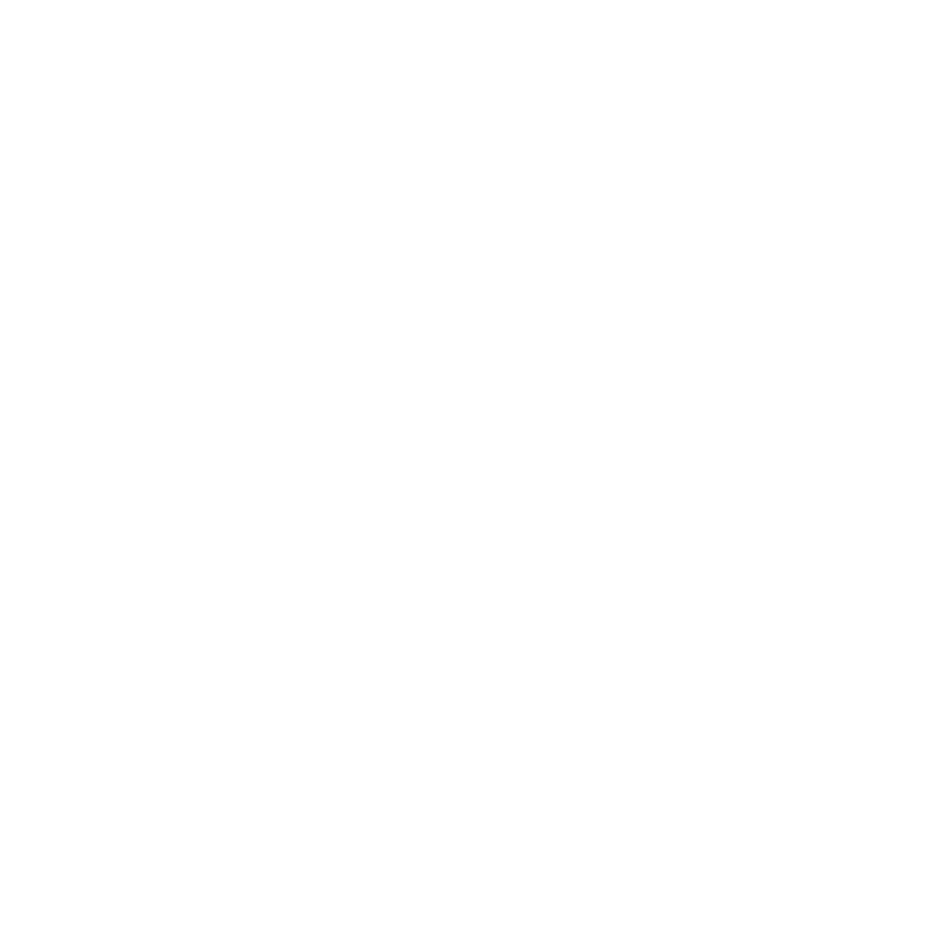

torch.Size([32, 2])


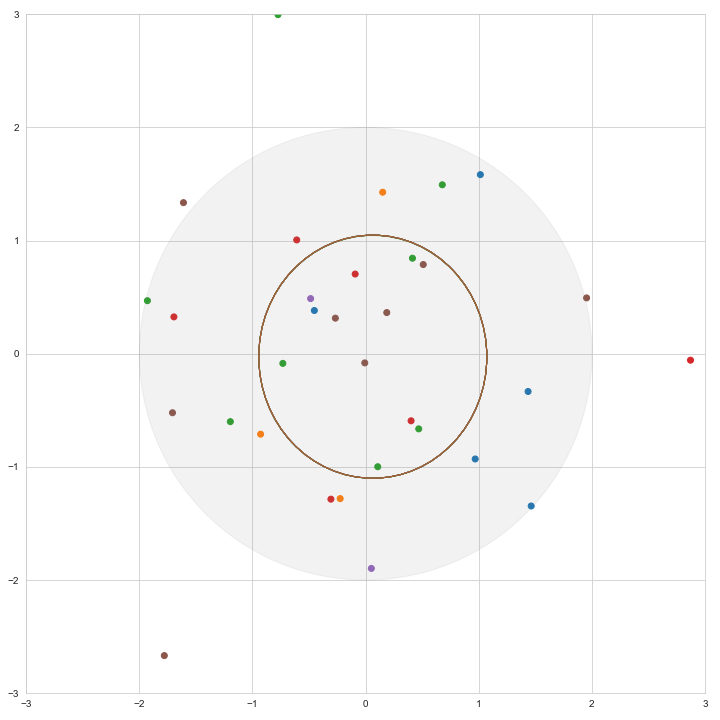

In [99]:
VAE_EX.show_plots(32)

<IPython.core.display.Javascript object>


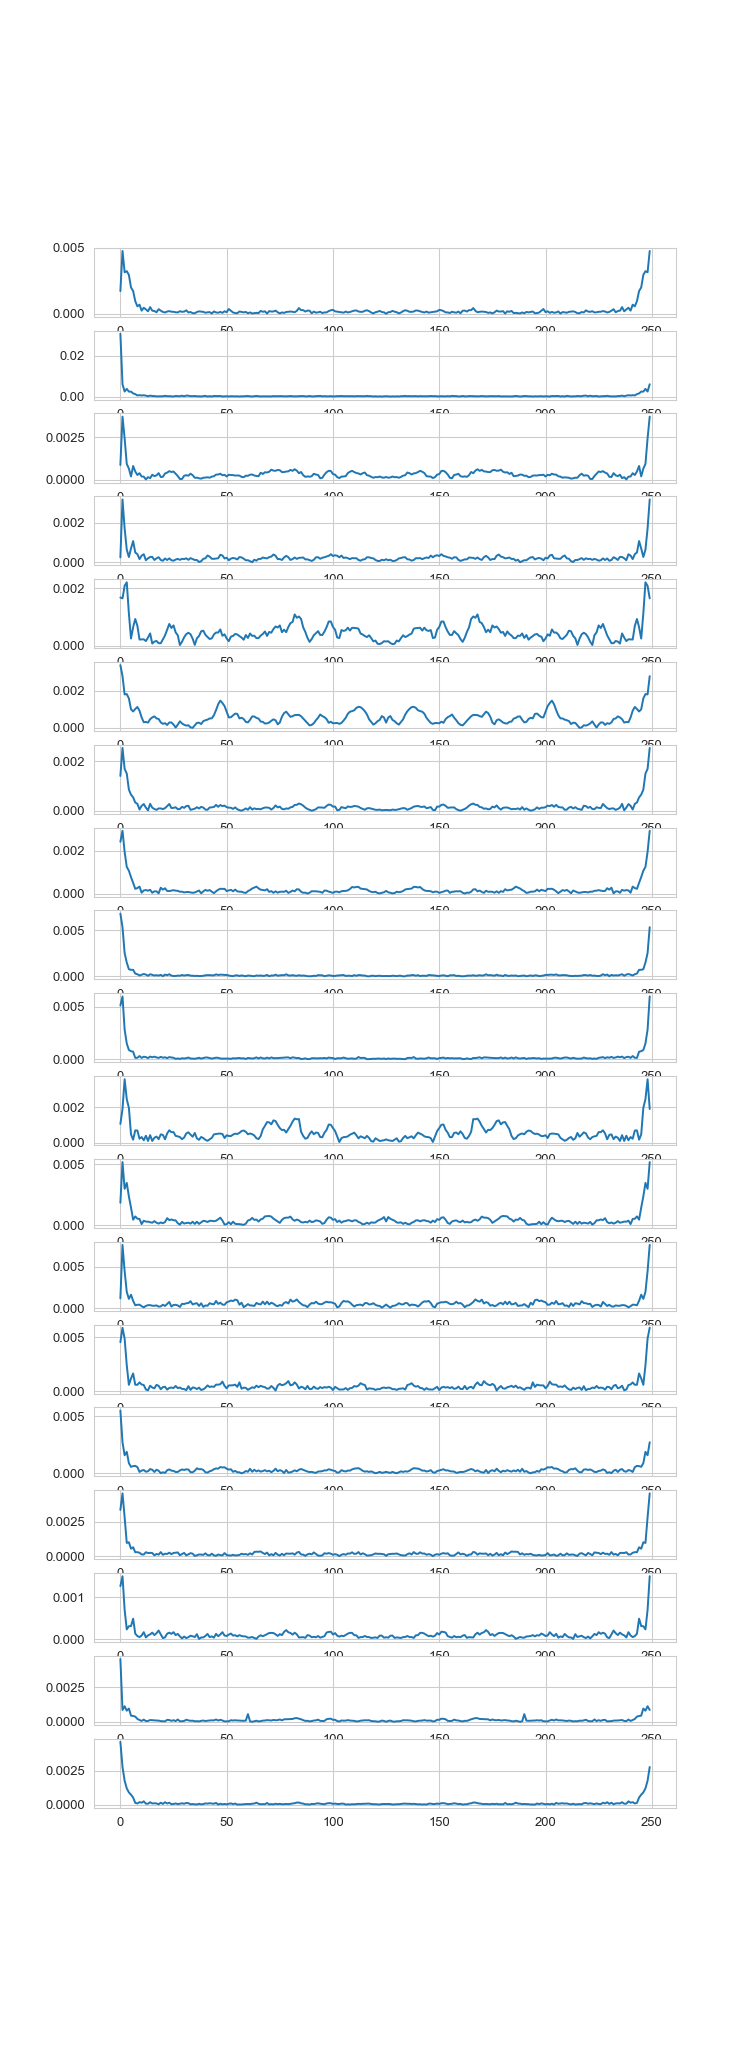

<IPython.core.display.Javascript object>


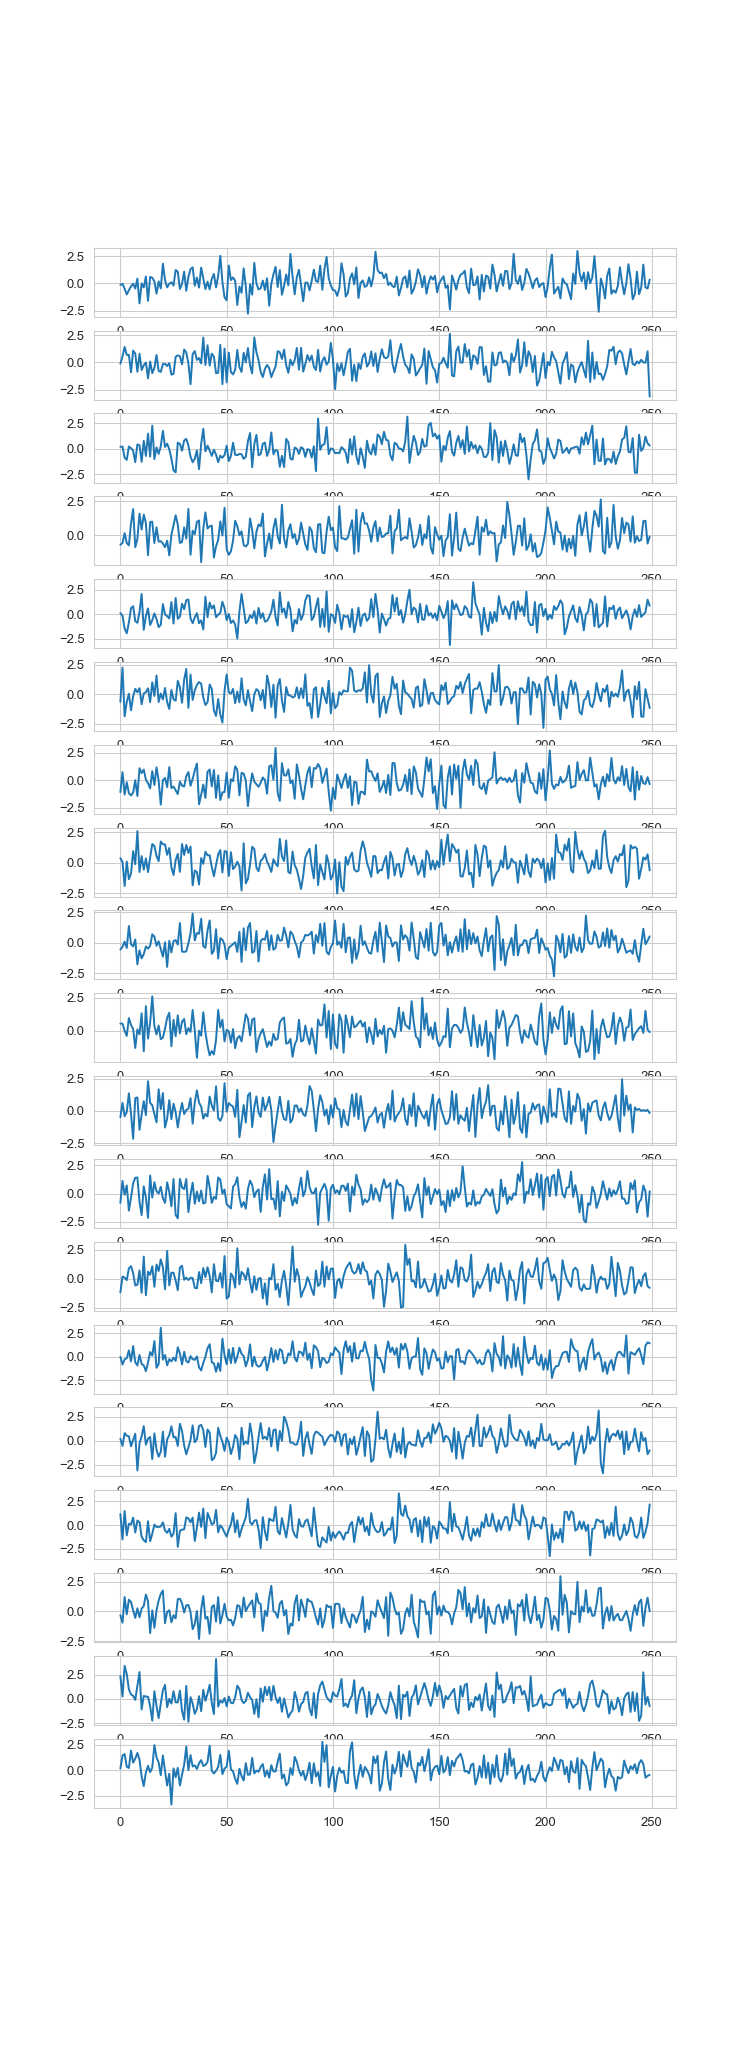

In [100]:
plot_samples(X.cpu(),"")
plot_samples(untrained_samples.cpu(),"")

### 5.(Report)Evaluate thetrained modelon the test set and report the number.

### Make a plots functions: right now it's random. 

In [87]:
from Code.MNEplotter import plot_2d_latents
X,Y,meta=validation_set.load_random(32)
trained_samples = VAE_EX.VAE.sample(X)
print(Y.shape)
plot_2d_latents(VAE_EX.outputs,Y)

torch.Size([32, 6])


<IPython.core.display.Javascript object>

torch.Size([30, 2])


ValueError: 'c' argument has 32 elements, which is not acceptable for use with 'x' with size 30, 'y' with size 30.

In [101]:
from torchvision.utils import make_grid

x_o = x[0]

px = outputs['px']
x_sample = px.sample().to('cpu')
x_r = x_sample[0]

channels = 19
fig, axs = plt.subplots(nrows= channels, ncols = 2,figsize=(15,20))

for i in range(channels):
    axs[i,0].plot(x_o[i])
    axs[i,1].plot(x_r[i])

NameError: name 'x' is not defined

In [27]:
TRIGGER ERROR TO STOP RUNNING

SyntaxError: invalid syntax (<ipython-input-27-aa1299fb8765>, line 1)

# 2.3  Semi-Supervised VAE (M1)

We have now trained a VAE on the full unlabeled dataset.  We will now implement the M1 modelfromSemi-Supervised Learning with Deep Generative Models. This amounts to simply traininga classifier on top of the representations learned by our VAE.

### 1.  Extract 100 labeled datapoints from MNIST (10 from each class).

In [39]:
x_train, y_train = load()  
z_train = vae.sample(x_train, z = True)

### 2.(Report)Train a classifier on their latent representation.  First try a linear classifier and thenexperiment with other types of classifiers.  Report the accuracies.

In [40]:
x_test, y_test = load()
z_test = vae.sample(x_test, z = True)

In [41]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
import seaborn as sn

def evaluate(y_true, y_pred, print_cm=False, print_err=False):
    
    # calculate and display confusion matrix
    labels = np.unique(y_true)
    names = ["null","eyem","chew","shiv","elpp","musc"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if print_cm:
        ax= plt.subplot()
        sn.heatmap(cm, annot=True, ax = ax, xticklabels=names, yticklabels=names, cmap = 'Reds', fmt = 'd')
        ax.set_xlabel('Predicted');
        ax.set_ylabel('True'); 

    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true, y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true, y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
    if print_err:
        print("")
        print("accuracy:", accuracy)
        print("precision:", precision)
        print("recall:", recall)
        print("f1 score:", f1)
        
    return [accuracy,precision,recall,f1]

### a) Linear classifier: SVM

**[SKIP]** Skip this section if training is not needed.

In [42]:
from sklearn import svm

clf = svm.SVC() 
SVM = clf.fit(z_train,y_train)    

C:\Users\blanc\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
'''
filename = 'Saved_Models/svc.pkl'
pickle.dump(SVC, open(filename, 'wb'))
'''

**[END SKIP]**

In [43]:
'''
filename = 'Saved_Models/svc.pkl'
SVC = pickle.load(open(filename, 'rb'))
'''

"\nfilename = 'Saved_Models/svc.pkl'\nSVC = pickle.load(open(filename, 'rb'))\n"

**Evaluate**

In [44]:
y_pred = SVM.predict(z_test)

C:\Users\blanc\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.125, 0.125, 0.4, 0.19047619047619047]

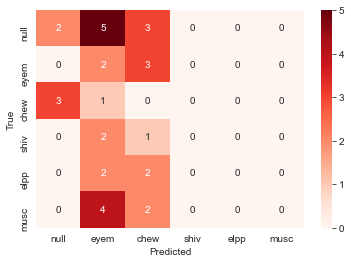

In [45]:
evaluate(y_test, y_pred, print_cm=True)

## b) Neural Network

In [47]:
#Hyperparameters
num_classes = 6
num_hidden_l1 = 500
num_hidden_l2 = 200
num_features = z_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_output):
        super(Net, self).__init__()  
        
        self.l_1 = Linear(in_features=num_features, 
                          out_features=num_hidden_l1,
                          bias=True)
        
        self.l_2 = Linear(in_features=num_hidden_l1, 
                          out_features=num_hidden_l2,
                          bias=True)
        
        self.l_out = Linear(in_features=num_hidden_l2, 
                            out_features=num_classes,
                            bias=False)

        self.drop_layer  = nn.Dropout(0.5) # Add dropout layer

        self.batchnorm_1 = nn.BatchNorm1d(num_hidden_l1)
        self.batchnorm = nn.BatchNorm1d(num_hidden_l1)

        # define activation function in constructor

    def forward(self, x):

        x = relu(self.l_1(x))
        x = relu(self.l_2(x))
       
        return softmax(self.l_out(x), dim=1)

net = Net(num_features, num_classes)
print(net)

Net(
  (l_1): Linear(in_features=2, out_features=500, bias=True)
  (l_2): Linear(in_features=500, out_features=200, bias=True)
  (l_out): Linear(in_features=200, out_features=6, bias=False)
  (drop_layer): Dropout(p=0.5, inplace=False)
  (batchnorm_1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [48]:
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.05) # Add momentum
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6) # use Adama instead # Use L2 regularization
criterion = nn.CrossEntropyLoss()

In [49]:
x_val, y_val = load()  
z_val = vae.sample(x_val, z = True)

In [50]:
from sklearn.metrics import accuracy_score

# setting hyperparameters and gettings epoch sizes
num_epochs = 50
num_samples_train = z_train.shape[0]
num_samples_valid = z_val.shape[0]

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    optimizer.zero_grad()
    output = net(z_train)
    y_pred = torch.max(output, 1)[1]
    curr_loss = criterion(y_pred, y_train)
    curr_loss.backward()
    optimizer.step()
        
    losses.append(cur_loss / num_samples_train)

    net.eval()
    ### Evaluate training
    output = net(z_train)
    preds = torch.max(output, 1)[1]
    train_targs = list(targets_train.numpy())
    train_preds = list(preds.data.numpy())

    ### Evaluate validation        
    output = net(z_valid)
    preds = torch.max(output, 1)[1]
    val_targs = list(targets_valid.numpy())
    val_preds = list(preds.data.numpy())
        
    train_acc_cur = accuracy_score(y_train, train_preds)
    valid_acc_cur = accuracy_score(y_val, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
y_train.data.numpy()

In [ ]:
criterion(y_pred, y_train)

In [ ]:
def generative_training(num_epochs,vae,train_loader):

  epoch = 0
  validation_data = defaultdict(list)

  while epoch < num_epochs:
   num_epochs = 10

   z = torch.zeros(num_epochs)
   loss = torch.zeros(num_epochs)

   while epoch < num_epochs:
      epoch+= 1
      x_batch,_ = getRandomMiniBatch(train_loader)
      for i in range(len(x_batch)):
            # sample zi from posterior q(zi|xi)
            loss[i],_,outputs = vae.variatonal_inference(x_batch[i])
            z[i] = outputs['z']
      # variational bound
      if epoch%10 == 0:
        print("Epoch {0}/{1}".format(epoch,num_epochs))
      epoch+= 1
      
      training_epoch_data = defaultdict(list)
      vae.train()
      zt,yt,xt = [],[],[]
      
      # Go through each batch in the training dataset using the loader
      # Note that y is not necessarily known as it is here
      for x, y in train_loader:
          x = x.to(device)
          
          # perform a forward pass through the model and compute the ELBO
          loss, diagnostics, outputs = vae.variatonal_inference(x)
          zt += outputs['z']
          yt += y
          xt += x
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # gather data for the current bach
          for k, v in diagnostics.items():
              training_epoch_data[k] += [v.mean().item()]

      for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

  with torch.no_grad():
    z = [i.numpy() for i in zt]
    y = [i.numpy() for i in yt]
    x = [i.numpy() for i in xt]

  return z,y,x